# Feature Engineering SIN Data Leakage

**Objetivo**: Predecir arribos en [T, T+30] usando SOLO información de [T-30, T] sin información de arribos.

**Eliminado para evitar data leakage**:
- Todas las features LAG (LAG1, LAG2, LAG3, etc.)
- Features de arribos (N_arribos_intervalo, N_ARRIBOS_LAG*, etc.)
- Features de destino (hora_destino, barrio_destino, etc.)
- Promedios basados en arribos (N_ARRIBOS_PROM_2INT, etc.)

**Información válida a usar**:
- Features de usuario (género, edad, modelo de bicicleta)
- Features de estación origen (barrio, cluster, popularidad)
- Features temporales basadas en origen/despacho
- Conteos históricos de SALIDAS (no arribos)


In [5]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np
import gc

import os
import sys
# sys.path.append(os.path.abspath('..'))
os.chdir('..')

print("=== FEATURE ENGINEERING SIN DATA LEAKAGE ===")
print("Objetivo: Predecir arribos [T, T+30] con info de [T-30, T] sin arribos")

# Cargar datos con ventanas ya creadas
trips = pd.read_csv('data/processed/trips_con_ventanas.csv')
print(f"\nDataset cargado: {trips.shape}")
print(f"Columnas: {list(trips.columns)}")

# trips

=== FEATURE ENGINEERING SIN DATA LEAKAGE ===
Objetivo: Predecir arribos [T, T+30] con info de [T-30, T] sin arribos


In [3]:
# Explorar estructura del dataset
print("=== EXPLORACIÓN DEL DATASET ===")
print(f"Forma del dataset: {trips.shape}")
print(f"\nColumnas disponibles:")
for i, col in enumerate(trips.columns):
    print(f"{i+1:2d}. {col}")

print(f"\nPrimeras 3 filas:")
print(trips.head(3))

print(f"\nTipos de datos:")
print(trips.dtypes)

print(f"\nValores únicos en columnas clave:")
print(f"Géneros: {trips['genero'].unique()}")
print(f"Modelos de bicicleta: {trips['modelo_bicicleta'].unique()}")

print(f"\nRango de fechas:")
print(f"Fecha origen min: {trips['fecha_origen_recorrido'].min()}")
print(f"Fecha origen max: {trips['fecha_origen_recorrido'].max()}")

=== EXPLORACIÓN DEL DATASET ===
Forma del dataset: (12785807, 22)

Columnas disponibles:
 1. id_recorrido
 2. duracion_recorrido
 3. id_estacion_origen
 4. nombre_estacion_origen
 5. direccion_estacion_origen
 6. long_estacion_origen
 7. lat_estacion_origen
 8. id_estacion_destino
 9. nombre_estacion_destino
10. direccion_estacion_destino
11. long_estacion_destino
12. lat_estacion_destino
13. id_usuario
14. modelo_bicicleta
15. genero
16. fecha_origen_recorrido
17. fecha_destino_recorrido
18. edad_usuario
19. fecha_alta
20. hora_alta
21. ventana_despacho
22. ventana_arribo

Primeras 3 filas:
   id_recorrido  duracion_recorrido  id_estacion_origen  \
0       7210548                1582                  27   
1       7199093                 204                 151   
2       7196805                1790                 111   

  nombre_estacion_origen         direccion_estacion_origen  \
0       027 - Montevideo          Cordoba Av. & Montevideo   
1       151 - AIME PAINÉ  Villaflor, Azu

In [4]:
# Exploremos la estructura del dataset
print("Forma del dataset:", trips.shape)
print("\nPrimeras 5 filas:")
print(trips.head())
print("\nTipos de datos:")
print(trips.dtypes)
print("\nValores únicos en algunas columnas clave:")
print("Generos:", trips['genero'].unique())
print("Modelos de bicicleta:", trips['modelo_bicicleta'].unique())
print("\nRango de fechas:")
print("Fecha origen min:", trips['fecha_origen_recorrido'].min())
print("Fecha origen max:", trips['fecha_origen_recorrido'].max())


Forma del dataset: (12785807, 22)

Primeras 5 filas:
   id_recorrido  duracion_recorrido  id_estacion_origen  \
0       7210548                1582                  27   
1       7199093                 204                 151   
2       7196805                1790                 111   
3       7203598               10688                 285   
4       7200335                 673                 171   

    nombre_estacion_origen            direccion_estacion_origen  \
0         027 - Montevideo             Cordoba Av. & Montevideo   
1         151 - AIME PAINÉ     Villaflor, Azucena & Paine, Aime   
2     111 - MACACHA GUEMES                   Machaca Guemes 350   
3  400 - Reserva Ecologica  Achaval Rodriguez, T., Dr. Av. 1520   
4            171 - Pasteur                          519 Pasteur   

   long_estacion_origen  lat_estacion_origen  id_estacion_destino  \
0            -58.390087           -34.599068                  3.0   
1            -58.361286           -34.611816       

In [5]:
# Verificar las ventanas de tiempo existentes
print("=== VERIFICACIÓN DE VENTANAS TEMPORALES ===")
print(f"\nEjemplos de ventanas:")
print(f"Ventana despacho (usaremos): {trips['ventana_despacho'].head(5).tolist()}")
print(f"Ventana arribo (NO usaremos): {trips['ventana_arribo'].head(5).tolist()}")

print(f"\nEjemplos de fechas:")
print(f"Fecha origen: {trips['fecha_origen_recorrido'].head(3).tolist()}")
print(f"Fecha destino: {trips['fecha_destino_recorrido'].head(3).tolist()}")

print(f"\n⚠️  IMPORTANTE: Usaremos SOLO ventana_despacho para evitar data leakage")
print(f"   - ventana_despacho: información disponible en [T-30, T]")
print(f"   - ventana_arribo: información que queremos predecir [T, T+30]")


=== VERIFICACIÓN DE VENTANAS TEMPORALES ===

Ejemplos de ventanas:
Ventana despacho (usaremos): ['2020-01-24 22:00:00', '2020-01-24 07:30:00', '2020-01-24 00:30:00', '2020-01-24 13:00:00', '2020-01-24 09:00:00']
Ventana arribo (NO usaremos): ['2020-01-24 22:00:00', '2020-01-24 07:00:00', '2020-01-24 00:30:00', '2020-01-24 15:30:00', '2020-01-24 08:30:00']

Ejemplos de fechas:
Fecha origen: ['2020-01-24 21:54:39', '2020-01-24 07:04:19', '2020-01-24 00:15:17']
Fecha destino: ['2020-01-24 22:21:01', '2020-01-24 07:07:43', '2020-01-24 00:45:07']

⚠️  IMPORTANTE: Usaremos SOLO ventana_despacho para evitar data leakage
   - ventana_despacho: información disponible en [T-30, T]
   - ventana_arribo: información que queremos predecir [T, T+30]


In [6]:
# Importar y usar la nueva clase sin data leakage
from filaxrecorrido.feature_engineering_bicis import BikeDataFeatureEngineerNoLeakage

print("=== INICIANDO FEATURE ENGINEERING SIN DATA LEAKAGE ===")

# Crear instancia del procesador sin data leakage
feature_engineer = BikeDataFeatureEngineerNoLeakage()

# Configurar rutas
input_path = 'data/processed/trips_con_ventanas.csv'
output_path = 'data/processed/trips_features_no_leakage.csv'

print(f"Archivo de entrada: {input_path}")
print(f"Archivo de salida: {output_path}")
print(f"\n🚫 FEATURES ELIMINADAS para evitar data leakage:")
print(f"   - Todas las LAG features")
print(f"   - Features de arribos")
print(f"   - Features de destino (hora, barrio, etc.)")
print(f"   - Promedios basados en arribos")


=== INICIANDO FEATURE ENGINEERING SIN DATA LEAKAGE ===
Archivo de entrada: data/processed/trips_con_ventanas.csv
Archivo de salida: data/processed/trips_features_no_leakage.csv

🚫 FEATURES ELIMINADAS para evitar data leakage:
   - Todas las LAG features
   - Features de arribos
   - Features de destino (hora, barrio, etc.)
   - Promedios basados en arribos


In [31]:
gc.collect()

15048

In [8]:
# Ejecutar la transformación completa SIN DATA LEAKAGE
print("=== EJECUTANDO TRANSFORMACIÓN ===")
df_transformed = feature_engineer.transform_dataset(input_path, output_path)


=== EJECUTANDO TRANSFORMACIÓN ===
=== Iniciando proceso de Feature Engineering SIN DATA LEAKAGE ===
Objetivo: Predecir arribos en [T, T+30] usando información de [T-30, T] sin arribos
Cargando dataset...
Dataset cargado: (12785807, 22)
Preparando features de fecha y hora...
Creando features de género...
Creando features de usuario...
Creando clusters de estaciones...
Calculando estaciones cercanas...
Creando ventanas de tiempo...
Calculando conteos históricos de salidas...
Creando features de popularidad de estaciones...
Creando features históricas específicas (_prev_n)...
Features objetivo: id_estacion_destino_prev_*, cantidad_estaciones_cercanas_destino_prev_*,
                  año/mes/dia/hora/minuto/segundo_destino_prev_*, N_ARRIBOS_prev_*, N_SALIDAS_prev_*
   Calculando arribos históricos...
   Calculando salidas históricas...
   Preparando datos históricos de destino (sin data leakage)...
   Creando features _prev_1 (T-30 min)...
     Agregando features de destino histórico _pre

In [9]:
# Mostrar resultados finales
print("=== RESULTADOS FINALES ===")

# Obtener features de entrenamiento
training_features = feature_engineer.get_training_features()

print(f"\n✅ Dataset transformado exitosamente!")
print(f"   - Forma final: {df_transformed.shape}")
print(f"   - Total de columnas: {len(df_transformed.columns)}")
print(f"   - Features para entrenamiento: {len(training_features)}")

print(f"\n📊 FEATURES PARA ENTRENAMIENTO ({len(training_features)}):")
for i, feature in enumerate(training_features):
    print(f"{i+1:2d}. {feature}")

print(f"\n📁 Archivo guardado como: {output_path}")


=== RESULTADOS FINALES ===

✅ Dataset transformado exitosamente!
   - Forma final: (12785807, 70)
   - Total de columnas: 70
   - Features para entrenamiento: 65

📊 FEATURES PARA ENTRENAMIENTO (65):
 1. id_estacion_origen
 2. zona_origen_cluster
 3. cantidad_estaciones_cercanas_origen
 4. popularidad_estacion_origen
 5. hora_promedio_estacion_origen
 6. id_usuario
 7. modelo_bicicleta
 8. edad_usuario
 9. año_alta
10. mes_alta
11. genero_FEMALE
12. genero_MALE
13. genero_OTHER
14. usuario_registrado
15. dia_semana
16. es_finde
17. estacion_del_anio
18. año_origen
19. mes_origen
20. dia_origen
21. hora_origen
22. minuto_origen
23. segundo_origen
24. año_intervalo
25. mes_intervalo
26. dia_intervalo
27. hora_intervalo
28. minuto_intervalo
29. N_salidas_historicas
30. id_estacion_destino_prev_1
31. id_estacion_destino_prev_2
32. id_estacion_destino_prev_3
33. cantidad_estaciones_cercanas_destino_prev_1
34. cantidad_estaciones_cercanas_destino_prev_2
35. cantidad_estaciones_cercanas_destin

In [10]:
# Verificar que no hay data leakage
print("=== VERIFICACIÓN DE DATA LEAKAGE ===")

# Verificar que no hay columnas LAG
lag_columns = [col for col in df_transformed.columns if 'LAG' in col]
print(f"\n🔍 Columnas LAG encontradas: {len(lag_columns)}")
if lag_columns:
    print(f"   ⚠️  ADVERTENCIA: Se encontraron columnas LAG: {lag_columns}")
else:
    print(f"   ✅ CORRECTO: No se encontraron columnas LAG")

# Verificar que no hay features de arribos
arribo_columns = [col for col in df_transformed.columns if 'arribo' in col.lower() or 'ARRIBO' in col]
print(f"\n🔍 Columnas de arribos encontradas: {len(arribo_columns)}")
if arribo_columns:
    print(f"   ⚠️  ADVERTENCIA: Se encontraron columnas de arribos: {arribo_columns}")
else:
    print(f"   ✅ CORRECTO: No se encontraron columnas de arribos")

# Verificar que no hay features de destino temporales
destino_temporal_columns = [col for col in df_transformed.columns if any(x in col for x in ['destino', 'hora_destino', 'barrio_destino'])]
print(f"\n🔍 Columnas de destino temporal encontradas: {len(destino_temporal_columns)}")
if destino_temporal_columns:
    print(f"   ⚠️  ADVERTENCIA: Se encontraron columnas de destino temporal: {destino_temporal_columns}")
else:
    print(f"   ✅ CORRECTO: No se encontraron columnas de destino temporal")

print(f"\n✅ VERIFICACIÓN COMPLETADA")
print(f"   Dataset preparado para predecir arribos [T, T+30] usando info [T-30, T]")


=== VERIFICACIÓN DE DATA LEAKAGE ===

🔍 Columnas LAG encontradas: 0
   ✅ CORRECTO: No se encontraron columnas LAG

🔍 Columnas de arribos encontradas: 7
   ⚠️  ADVERTENCIA: Se encontraron columnas de arribos: ['N_ARRIBOS_prev_1', 'N_ARRIBOS_prev_2', 'N_ARRIBOS_prev_3', 'N_ARRIBOS_prev_4', 'N_ARRIBOS_prev_5', 'N_ARRIBOS_prev_6', 'N_arribos_intervalo']

🔍 Columnas de destino temporal encontradas: 25
   ⚠️  ADVERTENCIA: Se encontraron columnas de destino temporal: ['id_estacion_destino', 'id_estacion_destino_prev_1', 'id_estacion_destino_prev_2', 'id_estacion_destino_prev_3', 'cantidad_estaciones_cercanas_destino_prev_1', 'cantidad_estaciones_cercanas_destino_prev_2', 'cantidad_estaciones_cercanas_destino_prev_3', 'año_destino_prev_1', 'año_destino_prev_2', 'año_destino_prev_3', 'mes_destino_prev_1', 'mes_destino_prev_2', 'mes_destino_prev_3', 'dia_destino_prev_1', 'dia_destino_prev_2', 'dia_destino_prev_3', 'hora_destino_prev_1', 'hora_destino_prev_2', 'hora_destino_prev_3', 'minuto_desti

In [11]:
# Mostrar estadísticas finales del dataset
print("=== ESTADÍSTICAS FINALES ===")

print(f"\n📈 Información del dataset final:")
print(f"   - Filas: {df_transformed.shape[0]:,}")
print(f"   - Columnas: {df_transformed.shape[1]}")
print(f"   - Memoria: {df_transformed.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print(f"\n🎯 Variables objetivo disponibles:")
print(f"   - id_estacion_destino: Estación donde predecir arribos")
print(f"   - Estaciones únicas de destino: {df_transformed['id_estacion_destino'].nunique()}")

print(f"\n⏱️  Ventanas temporales:")
print(f"   - Rango temporal: {df_transformed['fecha_intervalo'].min()} a {df_transformed['fecha_intervalo'].max()}")
print(f"   - Intervalos únicos: {df_transformed['fecha_intervalo'].nunique():,}")

print(f"\n✅ Dataset listo para entrenamiento sin data leakage!")


=== ESTADÍSTICAS FINALES ===

📈 Información del dataset final:
   - Filas: 12,785,807
   - Columnas: 70
   - Memoria: 6194.3 MB

🎯 Variables objetivo disponibles:
   - id_estacion_destino: Estación donde predecir arribos
   - Estaciones únicas de destino: 502

⏱️  Ventanas temporales:
   - Rango temporal: 2020-01-01 00:30:00 a 2024-09-01 00:00:00
   - Intervalos únicos: 79,115

✅ Dataset listo para entrenamiento sin data leakage!


In [12]:
# Verificar el resultado
print("=== RESULTADO DE LA TRANSFORMACIÓN ===")
print(f"Forma del dataset transformado: {df_transformed.shape}")
print(f"\nPrimeras columnas:")
print(df_transformed.columns.tolist()[:20])
print(f"\nPrimera fila de ejemplo:")
print(df_transformed.iloc[0])

# Obtener features de entrenamiento
training_features = feature_engineer.get_training_features()
print(f"\n=== FEATURES PARA ENTRENAMIENTO ===")
print(f"Total de features: {len(training_features)}")
print("Features:")
for i, feature in enumerate(training_features[:10]):  # Mostrar primeras 10
    print(f"  {i+1:2d}. {feature}")
print("  ... (y más)")


=== RESULTADO DE LA TRANSFORMACIÓN ===
Forma del dataset transformado: (12785807, 70)

Primeras columnas:
['id_recorrido', 'id_estacion_origen', 'id_estacion_destino', 'id_usuario', 'duracion_recorrido', 'modelo_bicicleta', 'edad_usuario', 'año_alta', 'mes_alta', 'genero_FEMALE', 'genero_MALE', 'genero_OTHER', 'usuario_registrado', 'zona_origen_cluster', 'cantidad_estaciones_cercanas_origen', 'popularidad_estacion_origen', 'hora_promedio_estacion_origen', 'dia_semana', 'es_finde', 'estacion_del_anio']

Primera fila de ejemplo:
id_recorrido                       7210548
id_estacion_origen                      27
id_estacion_destino                    3.0
id_usuario                        192009.0
duracion_recorrido                    1582
                              ...         
N_SALIDAS_prev_4                       0.0
N_SALIDAS_prev_5                       0.0
N_SALIDAS_prev_6                       1.0
N_arribos_intervalo                    1.0
fecha_intervalo        2020-01-24 22:

In [13]:
# OPCIONAL: Entrenar el modelo XGBoost (descomentar si quieres entrenar ahora)
# from train_xgboost_bicis import XGBoostBikePredictor

# # Crear predictor con GPU habilitada
# predictor = XGBoostBikePredictor(use_gpu=True)

# # Cargar y preparar datos
# df_model = predictor.load_data('data/processed/trips_features_engineered.csv')
# X, y = predictor.prepare_data(df_model)
# X_train, X_test, y_train, y_test = predictor.split_data(X, y)

# print(f"\n=== LISTO PARA ENTRENAR ===")
# print(f"Dataset para entrenamiento: {X_train.shape}")
# print(f"Features: {len(predictor.training_features)}")
# print("Para entrenar el modelo, ejecuta las siguientes líneas:")
# print("model = predictor.train_model(X_train, X_test, y_train, y_test)")
# print("metrics, y_pred = predictor.evaluate_model(X_test, y_test)")

print("🎯 Dataset transformado exitosamente!")
print("📝 Archivos creados:")
print("  - feature_engineering_bicis.py: Script de transformación")
print("  - train_xgboost_bicis.py: Script de entrenamiento XGBoost")
print("  - data/processed/trips_features_engineered.csv: Dataset transformado")
print("\n✅ ¡Todo listo para entrenar el modelo con XGBoost + GPU!")


🎯 Dataset transformado exitosamente!
📝 Archivos creados:
  - feature_engineering_bicis.py: Script de transformación
  - train_xgboost_bicis.py: Script de entrenamiento XGBoost
  - data/processed/trips_features_engineered.csv: Dataset transformado

✅ ¡Todo listo para entrenar el modelo con XGBoost + GPU!


In [ ]:
# ¡ENTRENAR EL MODELO XGBOOST! 🚀
from filaxrecorrido.train_xgboost_bicis import XGBoostBikePredictor

print("=== INICIANDO ENTRENAMIENTO DEL MODELO ===")
print("🚀 Configurando XGBoost con GPU...")

# Crear predictor con GPU habilitada
predictor = XGBoostBikePredictor(use_gpu=True)


=== INICIANDO ENTRENAMIENTO DEL MODELO ===
🚀 Configurando XGBoost con GPU...


In [ ]:
# ⚠️ REGENERAR DATASET CON CORRECCIONES ⚠️
print("🔧 Regenerando dataset con variables categóricas corregidas...")
import os

os.chdir('..')
# Reimportar el feature engineer actualizado
import importlib
import filaxrecorrido.feature_engineering_bicis
importlib.reload(filaxrecorrido.feature_engineering_bicis)
from filaxrecorrido.feature_engineering_bicis import BikeDataFeatureEngineerNoLeakage

# Crear nueva instancia
feature_engineer_fixed = BikeDataFeatureEngineerNoLeakage()

# Regenerar dataset corregido
print("📊 Ejecutando feature engineering corregido...")
df_transformed_fixed = feature_engineer_fixed.transform_dataset(
    'data/processed/trips_con_ventanas.csv',
    'data/processed/trips_features_engineered_fixed.csv'
)



🔧 Regenerando dataset con variables categóricas corregidas...
📊 Ejecutando feature engineering corregido...
=== Iniciando proceso de Feature Engineering SIN DATA LEAKAGE ===
Objetivo: Predecir arribos en [T, T+30] usando información de [T-30, T] sin arribos
Cargando dataset...
Dataset cargado: (12785807, 22)
Preparando features de fecha y hora...
Creando features de género...
Creando features de usuario...
Creando clusters de estaciones...
Calculando estaciones cercanas...
Creando ventanas de tiempo...
Calculando conteos históricos de salidas...
Creando features de popularidad de estaciones...
Creando features históricas específicas (_prev_n)...
Features objetivo: id_estacion_destino_prev_*, cantidad_estaciones_cercanas_destino_prev_*,
                  año/mes/dia/hora/minuto/segundo_destino_prev_*, N_ARRIBOS_prev_*, N_SALIDAS_prev_*
   Calculando arribos históricos...
   Calculando salidas históricas...
   Preparando datos históricos de destino (sin data leakage)...
   Creando featur

NameError: name 'predictor' is not defined

In [7]:

# Ahora cargar y preparar datos con el dataset corregido
print("\n📊 Cargando dataset corregido...")
df_model = predictor.load_data('data/processed/trips_features_engineered_fixed.csv')

print("🔧 Preparando datos para entrenamiento...")
X, y = predictor.prepare_data(df_model)

print("✂️ Dividiendo en train/test...")
X_train, X_test, y_train, y_test = predictor.split_data(X, y)

print(f"\n=== DATOS LISTOS ===")
print(f"📈 Dataset completo: {X.shape}")
print(f"🏋️ Entrenamiento: {X_train.shape}")
print(f"🧪 Prueba: {X_test.shape}")
print(f"🎯 Target: {y.name} (rango: {y.min():.0f} - {y.max():.0f})")


📊 Cargando dataset corregido...
Cargando dataset transformado...
Dataset cargado: (12785807, 82)
⚠️  Features faltantes: {'actividad_total_prev_3', 'duracion_promedio_prev_3', 'actividad_total_prev_6', 'actividad_total_prev_1', 'duracion_promedio_prev_4', 'duracion_promedio_prev_6', 'actividad_total_prev_5', 'barrio_origen', 'duracion_promedio_prev_5', 'actividad_total_prev_4', 'duracion_promedio_prev_1', 'actividad_total_prev_2', 'duracion_promedio_prev_2'}
🔧 Preparando datos para entrenamiento...
Preparando datos para entrenamiento...
Datos preparados: X=(12785807, 54), y=(12785807,)
Target stats: min=0.0, max=36.0, mean=2.75
✂️ Dividiendo en train/test...
Dividiendo datos...
Entrenamiento: X=(10228645, 54), y=(10228645,)
Prueba: X=(2557162, 54), y=(2557162,)

=== DATOS LISTOS ===
📈 Dataset completo: (12785807, 54)
🏋️ Entrenamiento: (10228645, 54)
🧪 Prueba: (2557162, 54)
🎯 Target: N_arribos_intervalo (rango: 0 - 36)


In [13]:
print(X_train.columns)
gc.collect()

Index(['id_estacion_origen', 'barrio_origen', 'zona_origen_cluster',
       'cantidad_estaciones_cercanas_origen', 'popularidad_estacion_origen',
       'hora_promedio_estacion_origen', 'id_usuario', 'modelo_bicicleta',
       'edad_usuario', 'año_alta', 'mes_alta', 'genero_FEMALE', 'genero_MALE',
       'genero_OTHER', 'usuario_registrado', 'dia_semana', 'es_finde',
       'estacion_del_anio', 'año_origen', 'mes_origen', 'dia_origen',
       'hora_origen', 'minuto_origen', 'segundo_origen', 'año_intervalo',
       'mes_intervalo', 'dia_intervalo', 'hora_intervalo', 'minuto_intervalo',
       'N_salidas_historicas', 'arribos_prev_1', 'arribos_prev_2',
       'arribos_prev_3', 'arribos_prev_4', 'arribos_prev_5', 'arribos_prev_6',
       'salidas_prev_1', 'salidas_prev_2', 'salidas_prev_3', 'salidas_prev_4',
       'salidas_prev_5', 'salidas_prev_6', 'duracion_promedio_prev_1',
       'duracion_promedio_prev_2', 'duracion_promedio_prev_3',
       'duracion_promedio_prev_4', 'duracion_pro

8404

In [10]:
# ¡ENTRENAR EL MODELO! 💪
print("=== 🚀 ENTRENANDO XGBOOST CON GPU 🚀 ===")
print("⏰ Esto puede tomar varios minutos dependiendo del tamaño del dataset...")
print("🔥 Usando GPU para acelerar el entrenamiento")

# Entrenar el modelo
model = predictor.train_model(X_train, X_test, y_train, y_test)


=== 🚀 ENTRENANDO XGBOOST CON GPU 🚀 ===
⏰ Esto puede tomar varios minutos dependiendo del tamaño del dataset...
🔥 Usando GPU para acelerar el entrenamiento
=== ENTRENANDO MODELO XGBOOST ===
🚀 GPU habilitada para XGBoost
Iniciando entrenamiento...
[0]	validation_0-rmse:2.86837	validation_1-rmse:2.86574
[100]	validation_0-rmse:1.59072	validation_1-rmse:1.59088
[200]	validation_0-rmse:1.58039	validation_1-rmse:1.58149
[300]	validation_0-rmse:1.57313	validation_1-rmse:1.57512
[400]	validation_0-rmse:1.56836	validation_1-rmse:1.57133
[500]	validation_0-rmse:1.56348	validation_1-rmse:1.56729
[600]	validation_0-rmse:1.55922	validation_1-rmse:1.56394
[700]	validation_0-rmse:1.55554	validation_1-rmse:1.56109
[800]	validation_0-rmse:1.55197	validation_1-rmse:1.55833
[900]	validation_0-rmse:1.54905	validation_1-rmse:1.55621
[999]	validation_0-rmse:1.54618	validation_1-rmse:1.55411
✅ Entrenamiento completado en: 0:01:11.822065


In [14]:
# Evaluar el modelo entrenadoprint("=== 📊 EVALUANDO MODELO ===")
metrics, y_pred = predictor.evaluate_model(X_train, y_train)

print(f"\n✅ ¡ENTRENAMIENTO COMPLETADO!")
print(f"📈 Métricas del modelo:")
for metric, value in metrics.items():
    print(f"   {metric}: {value:.4f}")


print("=== 📊 EVALUANDO MODELO ===")
metrics, y_pred = predictor.evaluate_model(X_test, y_test)

print(f"\n✅ ¡ENTRENAMIENTO COMPLETADO!")
print(f"📈 Métricas del modelo:")
for metric, value in metrics.items():
    print(f"   {metric}: {value:.4f}")

# Guardar el modelo
predictor.save_model()


=== EVALUANDO MODELO ===
MAE:  1.1203
MSE:  2.3907
RMSE: 1.5462
R²:   0.4590

✅ ¡ENTRENAMIENTO COMPLETADO!
📈 Métricas del modelo:
   MAE: 1.1203
   MSE: 2.3907
   RMSE: 1.5462
   R2: 0.4590
=== 📊 EVALUANDO MODELO ===
=== EVALUANDO MODELO ===
MAE:  1.1240
MSE:  2.4152
RMSE: 1.5541
R²:   0.4523

✅ ¡ENTRENAMIENTO COMPLETADO!
📈 Métricas del modelo:
   MAE: 1.1240
   MSE: 2.4152
   RMSE: 1.5541
   R2: 0.4523
Guardando modelo...
✅ Modelo guardado en: models/xgboost_bicis_model.pkl
✅ Metadatos guardados en: models/xgboost_bicis_metadata.pkl


=== 📊 ANÁLISIS DE RESULTADOS ===
🔍 Analizando importancia de features...


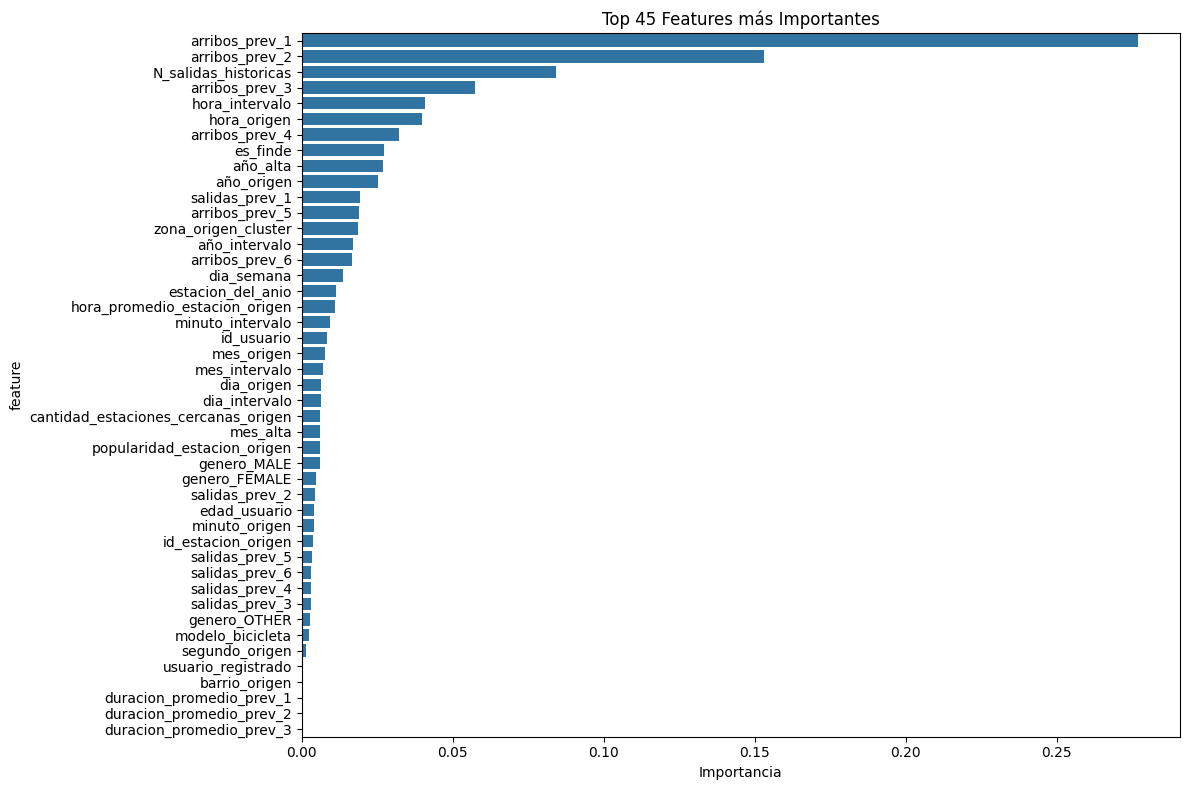


🎯 Top 10 Features más importantes:
   1. arribos_prev_1: 0.2769
   2. arribos_prev_2: 0.1531
   3. N_salidas_historicas: 0.0843
   4. arribos_prev_3: 0.0574
   5. hora_intervalo: 0.0409
   6. hora_origen: 0.0397
   7. arribos_prev_4: 0.0321
   8. es_finde: 0.0273
   9. año_alta: 0.0268
  10. año_origen: 0.0251

📈 Graficando predicciones vs valores reales...


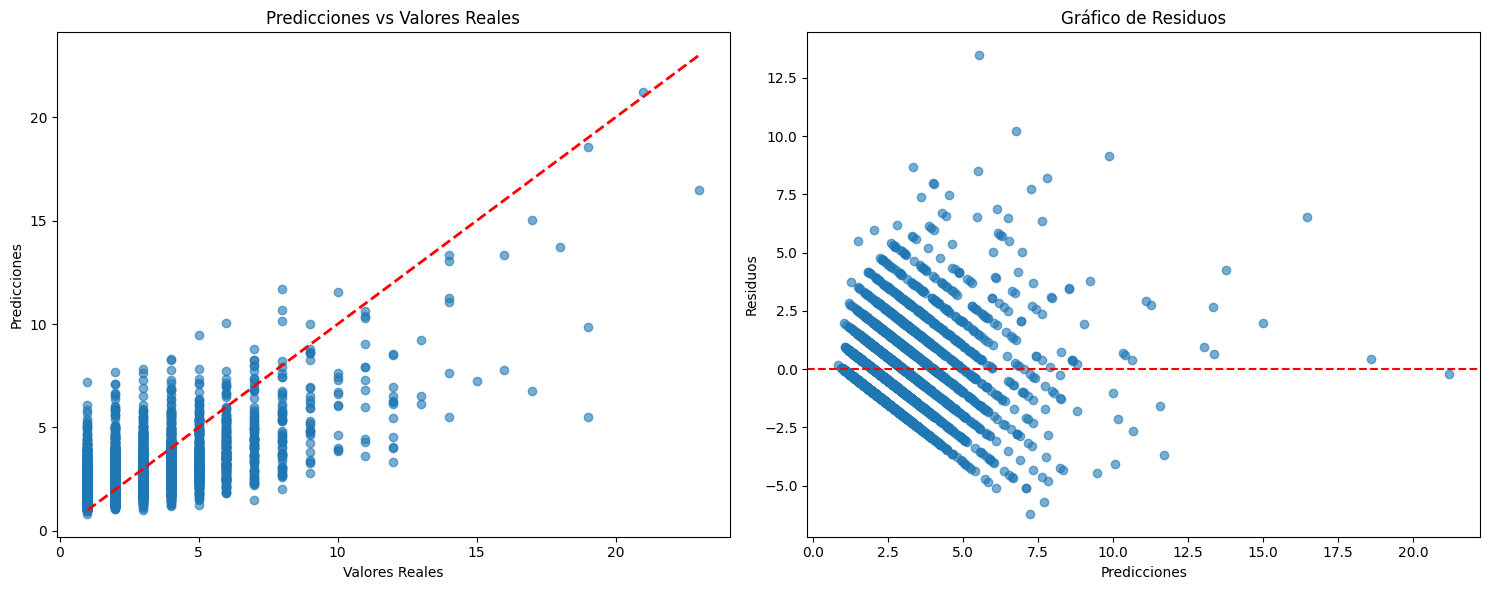

In [12]:
# Visualizar resultados
print("=== 📊 ANÁLISIS DE RESULTADOS ===")

# Mostrar importancia de features
print("🔍 Analizando importancia de features...")
feature_importance = predictor.plot_feature_importance(top_n=45)

print("\n🎯 Top 10 Features más importantes:")
for i, (idx, row) in enumerate(feature_importance.head(10).iterrows()):
    print(f"  {i+1:2d}. {row['feature']}: {row['importance']:.4f}")

# Visualizar predicciones
print("\n📈 Graficando predicciones vs valores reales...")
predictor.plot_predictions(y_test, y_pred, sample_size=5000)


In [11]:
# Resumen final
print("=== 🎉 RESUMEN FINAL DEL ENTRENAMIENTO ===")
print(f"🎯 Modelo: XGBoost para predicción de arribos de bicicletas")
print(f"📊 Dataset: {X.shape[0]:,} recorridos con {X.shape[1]} features")
print(f"🏋️ Entrenamiento: {X_train.shape[0]:,} samples")
print(f"🧪 Prueba: {X_test.shape[0]:,} samples")
print(f"🚀 GPU: {'Habilitada' if predictor.use_gpu else 'No disponible'}")
print(f"💾 Modelo guardado en: models/xgboost_bicis_model.pkl")

print(f"\n📈 Rendimiento final:")
for metric, value in metrics.items():
    if metric == 'R2':
        quality = "Excelente" if value > 0.9 else "Bueno" if value > 0.8 else "Aceptable" if value > 0.6 else "Mejorable"
        print(f"   {metric}: {value:.4f} ({quality})")
    else:
        print(f"   {metric}: {value:.4f}")

print(f"\n✅ ¡ENTRENAMIENTO COMPLETADO EXITOSAMENTE! 🎊")
print(f"🔮 El modelo está listo para hacer predicciones de arribos a estaciones")


=== 🎉 RESUMEN FINAL DEL ENTRENAMIENTO ===
🎯 Modelo: XGBoost para predicción de arribos de bicicletas
📊 Dataset: 12,785,807 recorridos con 54 features
🏋️ Entrenamiento: 10,228,645 samples
🧪 Prueba: 2,557,162 samples
🚀 GPU: Habilitada
💾 Modelo guardado en: models/xgboost_bicis_model.pkl

📈 Rendimiento final:
   MAE: 1.1249
   MSE: 2.4217
   RMSE: 1.5562
   R2: 0.4508 (Mejorable)

✅ ¡ENTRENAMIENTO COMPLETADO EXITOSAMENTE! 🎊
🔮 El modelo está listo para hacer predicciones de arribos a estaciones
